In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload 2
import guitarsounds
from guitarsounds import Sound
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import DEV_utils as du
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d, InterpolatedUnivariateSpline, RectBivariateSpline
import scipy.signal

# Load all string sound files

In [3]:
wood_sounds = du.load_wood_sounds()
carbon_sounds = du.load_carbon_sounds()
nylon_sounds = du.load_nylon_sounds()
all_sounds = wood_sounds + carbon_sounds + nylon_sounds
notes = du.get_notes_names()
wood_sounds = du.arr2notedict(wood_sounds)
carbon_sounds = du.arr2notedict(carbon_sounds)
nylon_sounds = du.arr2notedict(nylon_sounds)

# What happened

## General
- Article (no news, in review)
- Clean up everything
- Repository for website for psychoacoustics

## Random envelop parameter sound generation

- Use pre-generated arrays saved in binary


In [75]:
def generate_chord(env_param=0, strum_interval=0.12, sr=22050, which='wood'):
    notes = ['E6', 'A5', 'D4', 'G3', 'B2', 'E1']
    arrays = [np.load(f'assets/sound_arrays/{which}/{note}.npy') for note in notes]
    array_size = arrays[0].shape[0]
    strum_sample_interval = int(strum_interval * sr)
    chord = np.zeros(array_size + 6 * strum_sample_interval)
    i = 0
    correction = [1, 0.95, 0.94, 0.90, 0.88, 0.80]
    for j, arr in enumerate(arrays):
        arr = apply_onset_to_array(arr, env_param)
        arr = fadeout_sigarr(arr)
        chord[i:i + array_size] += arr * correction[j]
        i += strum_sample_interval

    chord *= 0.95 / np.max(np.abs(chord))
    return chord

def random_envelop_parameter(other=None, bounds=(-1, 1)):
    interval = bounds[1] - bounds[0]
    param = np.random.rand()*interval + bounds[0]
    return param

In [84]:
sig = du.arr2sig(chord2)
sig.save_wav('dummy_sound2')


In [79]:
p1 = random_envelop_parameter(bounds=(-2, 2))
p2 = random_envelop_parameter(bounds=(-2, 2))
chord1 = generate_chord(env_param=p1)
chord2 = generate_chord(env_param=p2)
print(f'envelop parameter = {p1}')
du.listen_sig_array(chord1)
print(f'envelop parameter = {p2}')
du.listen_sig_array(chord2)

envelop parameter = -0.751070552396083


envelop parameter = 0.9553460523124873


# Mean Peak data 2D interpolator

Create an interpolator for the An data extracted from peaks so that we can do transformations on it before summing the sinus values

In [19]:
def subsig_divide(s, max_time=2):
    """ Divide a sound in sub signals """
    n_intervals = int(du.get_arrgen_interval(s) * max_time)
    time_intervals = np.linspace(0.13, max_time, n_intervals)
    center_times = [np.mean([time_intervals[i], time_intervals[i + 1]]) for i in range(len(time_intervals) - 1)]
    # Sound division in sub intervals
    sub_sigs = []
    for i, _ in enumerate(time_intervals[:-1]):
        # create a signal from subset indexes
        idx1 = du.time_index(s.signal, time_intervals[i])
        idx2 = du.time_index(s.signal, time_intervals[i + 1])
        new_sig = guitarsounds.Signal(s.signal.signal[idx1:idx2], s.signal.sr, s.SP)
        sub_sigs.append(new_sig)
    return sub_sigs, center_times

def apply_onset_to_array(sigarr, expenv_param=0, sr=22050):
    """ Apply the onset envelop to a inverse FFT signal """
    env = du.get_expenv(expenv_param)
    # Apply it to time = 0.0 - 0.1 s
    t_idx = int(sr * 0.1)
    time = np.arange(0, 0.1, 1/sr)
    sigarr[:t_idx] = env(time[:t_idx]) * sigarr[:t_idx]
    return sigarr

def compute_peak_frequencies(s):
    """ Peak frequencies of a Sound """
    # Extract peak data
    s.signal.SP.change('fft_range', 12000)
    peaks = s.signal.peaks()
    peak_freqs = s.signal.fft_frequencies()[peaks]
    return peak_freqs

def truncated_time(s, max_time=2):
    """ Truncated time vector of a Sound """
    # Extract the time vector
    t = s.signal.time()
    t = t[t < max_time]
    return t

def signal_time(max_time, sr=22050):
    """ Time vector with sample rate sr """
    return np.linspace(0, max_time, int(max_time*22050))

def get_An_data(s, max_time=2):
    """ An data from a list of sub signals with peak freqs """
    sub_sigs, center_times = subsig_divide(s, max_time=max_time)
    peak_freqs = compute_peak_frequencies(s)
    all_amps = []
    for i, pf in enumerate(peak_freqs):
        # Time based amplitudes
        time_amps = []
        for sig in sub_sigs:
            fidx = du.frequency_index(sig, pf)
            time_amps.append(du.real_fft(sig)[fidx])
        all_amps.append(time_amps)
    return np.array(all_amps), np.array(center_times)

def condition_An_data_old(all_amps, treshold=0.1):
    """ Condition An data for better numerical behaviour """
    An_max = np.max(np.abs(all_amps))
    all_amps = treshold*np.abs(all_amps)/An_max
    return all_amps

def condition_An_data(all_amps, treshold):
    all_amps = condition_An_data_old(all_amps)
    for i in range(all_amps.shape[1]):
        #if np.sqrt(np.sum(all_amps[:, i])) > 1:
        all_amps[:, i] = all_amps[:, i] / np.sum(all_amps[:, i])
    return all_amps

def fadeout_sigarr(sigarr, sr=22050):
    n_samples = int(0.1 * sr)
    fadeout = np.linspace(1, 0.1, n_samples)
    sigarr[-n_samples:] *= fadeout
    return sigarr


def signal_from_An(center_times, peak_freqs, all_amps,  max_time=2, onset_env=3):
    """ Construct a signal array from an interpolator """
    An_itrp_2D = interp2d(center_times, peak_freqs, all_amps, kind='cubic')
    t = signal_time(max_time)
    An_values = An_itrp_2D(t, peak_freqs)
    
    new_sig = 0
    for i, pf in enumerate(peak_freqs):
        new_sig += An_values[i]* np.sin(pf * t * 2 * np.pi)
        
    new_sig *= 0.95/np.max(np.abs(new_sig))
    new_sig = apply_onset_to_array(new_sig, onset_env)
    new_sig = fadeout_sigarr(new_sig)
    return new_sig

def signal_generator(s, onset_env=0, treshold=0.2, use_old=False):
    """ Generate a signal array from a Sound object """
    all_amps, center_times = get_An_data(s)
    if use_old:
        all_amps = condition_An_data_old(all_amps)
    else:
        all_amps = condition_An_data(all_amps, treshold=treshold)
    peak_frequencies = compute_peak_frequencies(s)
    sigarr = signal_from_An(center_times, peak_frequencies, all_amps, onset_env=onset_env)
    return sigarr


In [26]:
s = wood_sounds['A5']
new_sig = signal_generator(s, onset_env=-1, treshold=0.01)
old_sig = signal_generator(s, use_old=True)
        

print('Original')
s.signal.normalize().trim_time(2).listen()
print('Generated old')
du.listen_sig_array(old_sig)
print('Generated new')
du.listen_sig_array(new_sig)
print('Generated 1D')
du.listen_sig_array(fadeout_sigarr(arr))

Original


Generated old


Generated new


Generated 1D


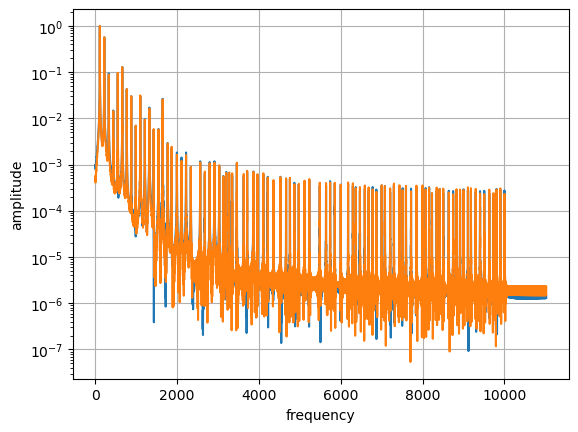

In [31]:
sig1 = du.arr2sig(arr)
sig1.SP.change('fft_range', 12000)
sig1.plot.fft()
sig2 = du.arr2sig(old_sig)
sig2.SP.change('fft_range', 12000)
sig2.plot.fft()


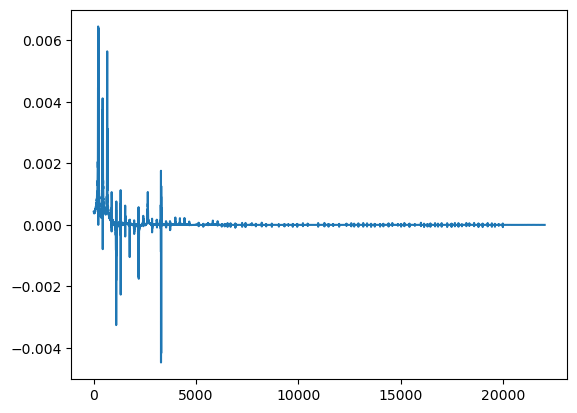

In [32]:
plt.plot(sig1.fft() - sig2.fft())

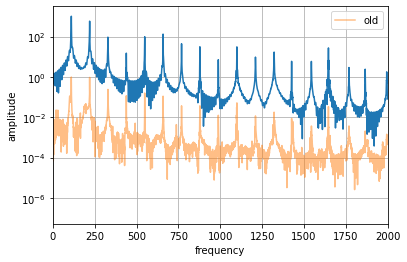

In [96]:
snew = du.arr2sig(old_sig)
plt.plot(snew.fft_frequencies(), du.real_fft(snew) )
s.plot.fft(alpha=0.5, label='old')
plt.gca().set_xlim(0, 2000)
plt.legend()


### Adding a perturbation

# TODO

- [x] Period based reconstruction
- [x] Tune the FFT peak based reconstruction
- [x] Construct the An map before summing the sin values
- envelope fonction de la fréquence
- [x] Article
- Powerpoint

pafi.univ-lemans.fr
 
Vous pouvez sauter par-dessus les avertissement de certificats non-sécuritaires.
 
Identifiant : BRUAND    (majuscules)
Mot de passe :  PAFI2018   (majuscules)
